<a href="https://colab.research.google.com/github/sangse/Stock-AI/blob/main/%EC%8B%A0%EA%B7%9C%EC%83%81%EC%9E%A5%EC%A2%85%EB%AA%A9_%ED%8C%A8%ED%84%B4_Classification_%EB%AA%A8%EB%8D%B8_(with_CNN%2C_Kmeans).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def df_slicing_window(df, window_size, shift_size):
  total_length = len(df)
  # 항상 마지막 부분까지 포함하기 위해 올림을 사용
  numofblock = math.ceil((total_length - window_size) / shift_size) + 1
  # 데이터 블럭들을 저장하는 리스트
  data_list = []
  target_list = []
  for num in range(numofblock):
      start_index = num * shift_size
      end_index = start_index + window_size
      # 인덱스 범위가 데이터 길이를 초과하지 않도록 처리

      if end_index > total_length:
          break
      data_list.append(df.iloc[start_index:end_index])
      target_list.append(df.iloc[end_index:end_index+12])
  return data_list,target_list

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


# 디렉토리 경로
directory = '/content/drive/MyDrive/data/신규상장데이터'

# 해당 디렉토리 안의 파일 이름들을 리스트로 가져옴
file_names = os.listdir(directory)

min_max_scaler = MinMaxScaler()

train_data = []
target_data = []


for name in file_names:
  # 파일 데이터프레임으로 저장하고 일자를 인덱스를 정립하고 오름차순으로 정렬. 상장후 81일치 데이터만 사용.
  tmp = pd.read_csv(os.path.join(directory, name),encoding='cp949').head(81)
  tmp['일자'] = pd.to_datetime(tmp['일자'],format='%Y%m%d')
  tmp = tmp.sort_values(by='일자',ascending=True)
  tmp.set_index('일자',inplace=True)

  # 공모가 대비 현재가 특징 추가
  tmp['공모대비현재가비율'] = tmp['현재가']/tmp['공모가']

  # Minmax scaler
  tmp['현재가'] = min_max_scaler.fit_transform(tmp[['현재가']])
  tmp['저가'] = min_max_scaler.fit_transform(tmp[['저가']])
  tmp['고가'] = min_max_scaler.fit_transform(tmp[['고가']])
  tmp['시가'] = min_max_scaler.fit_transform(tmp[['시가']])
  tmp['거래량'] = min_max_scaler.fit_transform(tmp[['거래량']])
  tmp['거래대금'] = min_max_scaler.fit_transform(tmp[['거래대금']])

  # 필요없는 특징들은 제거
  drop_list = ['대업종구분',	'소업종구분',	'종목정보' ,'종목코드','Unnamed: 0','종목명','시장구분','공모가','상장등락률']
  tmp.drop(drop_list,axis=1,inplace=True)


  # NaN 값이 하나라도 있으면 건너뛰기
  if tmp.isna().any().any():
      continue
  # 데이터를 window size 24 , shift_size 5로 잘라준다.
  train_data += df_slicing_window(tmp,24,4)

train_data = np.array(train_data)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarni

In [ ]:
train_data.shape

(5306, 24, 7)

### CNN 기반 Encoder Decoder 학습

In [ ]:
# Explain -> 주가데이터를 24*10 형태의 feature map으로 형상하고 convolution을 Encoder를 통해 특성을 추출한다. 추출한 특성은 다시 Decoder로 24*1 형태로 복원하고
#             이렇게 얻은 24*1은 Input 현재가 특성을 재구성하는 것을 목적으로한다. Loss는 Input(24*10) 중의 현재가 특성과의 RMSE를 취한다.
# train data shape = (6395, 12, 7)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


# 인코더 정의
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # MaxPooling 추가
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # MaxPooling 추가

        self.flatten = nn.Flatten(start_dim=1)
        # 풀링으로 인해 특성 맵 크기 재계산 필요
        self.fc1 = nn.Linear(32 * 6 * 2, 10)  # 3차원 벡터 출력

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# 디코더 정의
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(10, 32 * 6 * 2)
        # 첫 번째 레이어 설정 변경 없음
        self.conv1 = nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1)
        # 두 번째 레이어 설정 변경
        self.conv2 = nn.ConvTranspose2d(16, 1, kernel_size=(4, 3), stride=(2, 2), padding=1)


    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, 32, 6, 2)  # 4차원 형태로 변환
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        return x

# 손실 함수 정의 (RMSE)
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, input, target):
        return torch.sqrt(torch.mean((input - target) ** 2))

# 인코더와 디코더 인스턴스 생성
encoder = Encoder()
decoder = Decoder()


# 최적화 설정
criterion = RMSELoss()  # RMSE 손실 함수 사용
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)


train_dataset = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# 학습
num_epochs = 200
for epoch in range(num_epochs):
    for data in train_loader:
        optimizer.zero_grad()
        reconstructions = decoder(encoder(data))  # 인코더-디코더 연결하여 복원
        loss = criterion(reconstructions, data)  # 복원된 이미지와 원본 이미지 간의 RMSE 손실 계산
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')



Epoch [1/200], Loss: 0.9825141429901123
Epoch [2/200], Loss: 1.2838752269744873
Epoch [3/200], Loss: 0.9156598448753357
Epoch [4/200], Loss: 0.2367335855960846
Epoch [5/200], Loss: 0.15853610634803772
Epoch [6/200], Loss: 0.1536642611026764
Epoch [7/200], Loss: 0.13079871237277985
Epoch [8/200], Loss: 0.12933263182640076
Epoch [9/200], Loss: 0.11731624603271484
Epoch [10/200], Loss: 0.14874789118766785
Epoch [11/200], Loss: 0.11386431753635406
Epoch [12/200], Loss: 0.0922280102968216
Epoch [13/200], Loss: 0.10019934177398682
Epoch [14/200], Loss: 0.10180408507585526
Epoch [15/200], Loss: 0.10449157655239105
Epoch [16/200], Loss: 0.10228665173053741
Epoch [17/200], Loss: 0.10263030230998993
Epoch [18/200], Loss: 0.10424444824457169
Epoch [19/200], Loss: 0.0970064252614975
Epoch [20/200], Loss: 0.1012583076953888
Epoch [21/200], Loss: 0.07891238480806351
Epoch [22/200], Loss: 0.09242089092731476
Epoch [23/200], Loss: 0.11463293433189392
Epoch [24/200], Loss: 0.11344696581363678
Epoch [25

<Axes: >

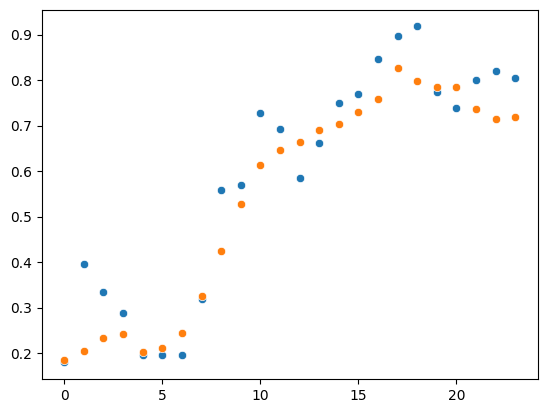

In [ ]:
test = decoder(encoder(train_dataset[:32,:,:,:]))

sns.scatterplot(train_dataset[8,0,:,0].detach().numpy())
sns.scatterplot(test[8,0,:,0].detach().numpy())

## Clustering Model

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


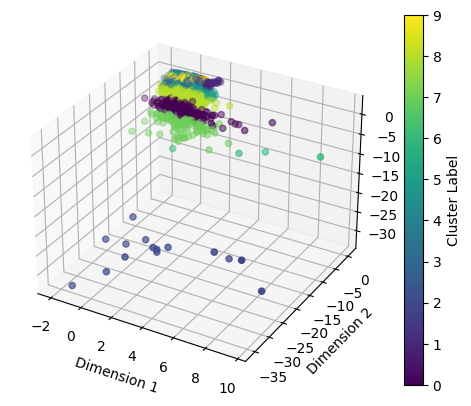

In [ ]:
# 5차원 벡터이지만 비전으로 볼수 있게끔 3차원만 써서 clustering 했습니다.

import numpy as np
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Ensure the encoder is in evaluation mode
encoder.eval()

# Get the vectors from the encoder
# Note: You might need to pass the data through DataLoader if it's too large to process at once
with torch.no_grad():
    vectors = encoder(train_dataset).detach().cpu().numpy()

# Perform K-means clustering
cluster_num = 10
kmeans = KMeans(n_clusters=cluster_num)
kmeans.fit(vectors)

# Extract cluster labels
labels = kmeans.labels_

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the encoded vectors, colored by cluster label
scatter = ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], c=labels, cmap='viridis')

# Add a color bar to indicate cluster labels
colorbar = plt.colorbar(scatter, ax=ax)
colorbar.set_label('Cluster Label')

# Set labels for axes
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

# Show the plot
plt.show()


In [ ]:
# 라벨별로 데이터를 분류하기 위한 딕셔너리 초기화
clustered_datasets = {i: [] for i in range(cluster_num)}  # 클러스터 개수가 15개라고 가정

# 각 데이터 포인트를 해당 클러스터 라벨에 따라 분류
for idx, label in enumerate(labels):
    clustered_datasets[label].append(train_dataset[idx])

# 필요에 따라 각 클러스터 데이터셋을 Tensor로 변환 및 DataLoader로 래핑
for label in clustered_datasets:
    # 리스트를 Tensor로 변환
    clustered_datasets[label] = torch.stack(clustered_datasets[label])


In [ ]:
for k in clustered_datasets:
  print(clustered_datasets[k].shape)

torch.Size([174, 1, 24, 7])
torch.Size([1713, 1, 24, 7])
torch.Size([15, 1, 24, 7])
torch.Size([575, 1, 24, 7])
torch.Size([888, 1, 24, 7])
torch.Size([554, 1, 24, 7])
torch.Size([4, 1, 24, 7])
torch.Size([103, 1, 24, 7])
torch.Size([349, 1, 24, 7])
torch.Size([931, 1, 24, 7])


### Clustering Result

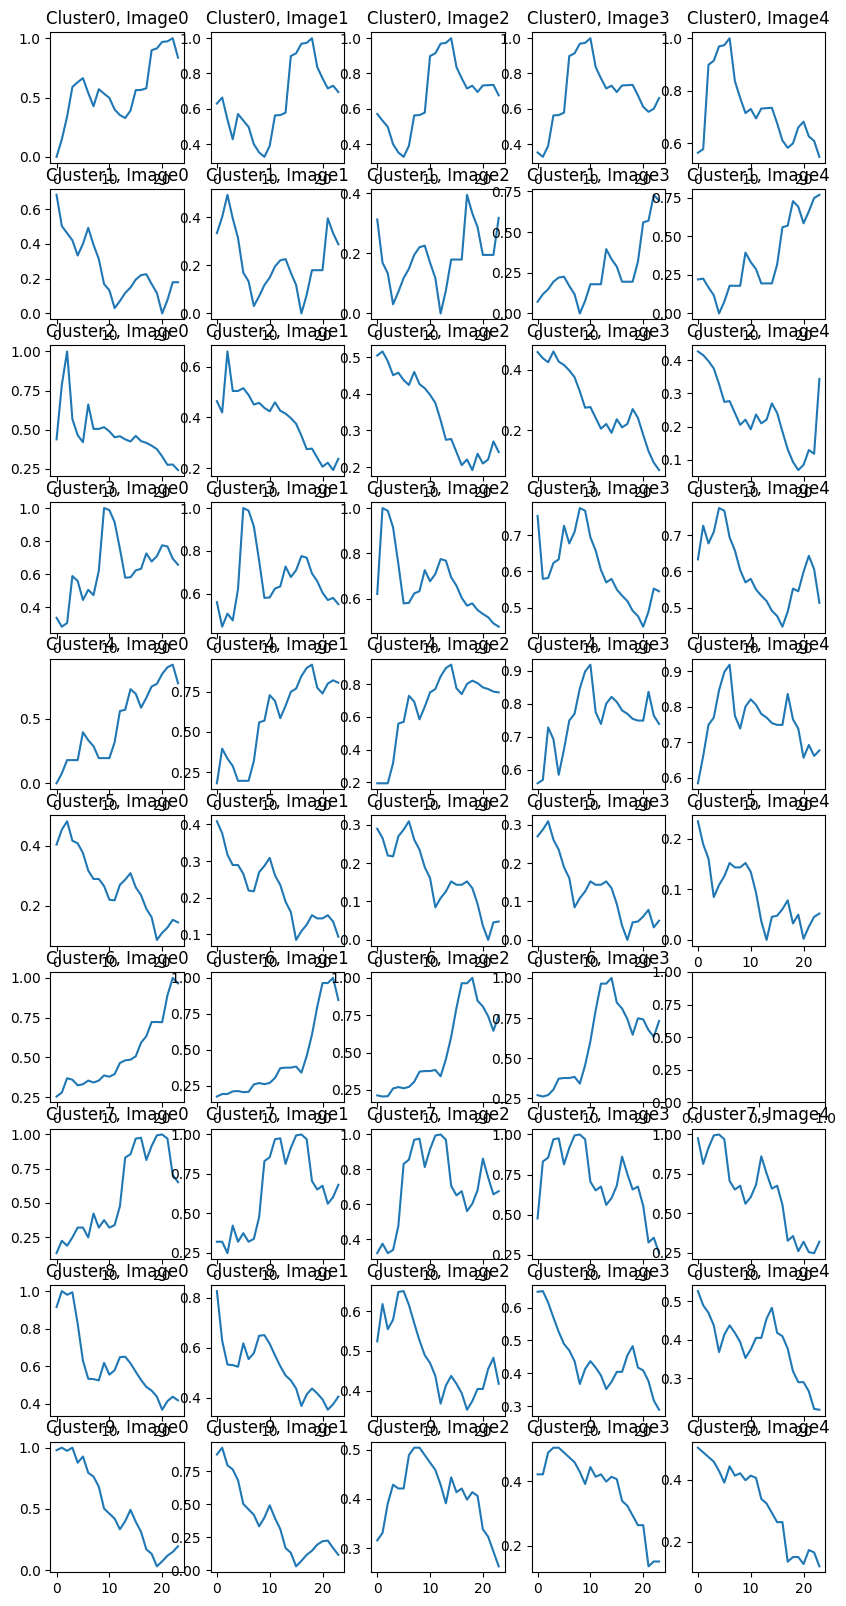

In [ ]:
# 각 군집의 5개 샘플 확인. encoder 10개 차원 벡터로 나온 clustering
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=cluster_num, ncols=5 ,figsize=(10, 20))
for k in range(cluster_num):
  for z in range(5):
    try:
      sns.lineplot(clustered_datasets[k][z,0,:,0],ax=axes[k][z])
      axes[k][z].set_title(f"Cluster{k}, Image{z}")
    except:
      pass
plt.show()

In [ ]:
# 각 군집의 5개 샘플 확인. encoder 7개 차원 벡터로 나온 clustering
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=10, ncols=5 ,figsize=(10, 20))
for k in range(10):
  for z in range(5):
    sns.lineplot(clustered_datasets[k][z,0,:,0],ax=axes[k][z])
    axes[k][z].set_title(f"Cluster{k}, Image{z}")
plt.show()

## 모델을 통한 예측 DLinear

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

def df_slicing_window_2(df, window_size, shift_size):
  total_length = len(df)
  # 항상 마지막 부분까지 포함하기 위해 올림을 사용
  numofblock = math.ceil((total_length - window_size) / shift_size) + 1
  # 데이터 블럭들을 저장하는 리스트
  data_list = []
  target_list = []
  for num in range(numofblock):
      start_index = num * shift_size
      end_index = start_index + window_size
      # 인덱스 범위가 데이터 길이를 초과하지 않도록 처리

      if end_index+24 > total_length:
          break

      data_list.append(df.iloc[start_index:end_index])
      target_list.append(df.iloc[end_index:end_index+24])
  return data_list,target_list

def data_X_y_extraction():
  # 디렉토리 경로
  directory = '/content/drive/MyDrive/data/신규상장데이터'

  # 해당 디렉토리 안의 파일 이름들을 리스트로 가져옴
  file_names = os.listdir(directory)

  min_max_scaler = MinMaxScaler()

  train_data = []
  target_data = []


  for name in file_names:
    # 파일 데이터프레임으로 저장하고 일자를 인덱스를 정립하고 오름차순으로 정렬. 상장후 81일치 데이터만 사용.
    tmp = pd.read_csv(os.path.join(directory, name),encoding='cp949').head(81)
    tmp['일자'] = pd.to_datetime(tmp['일자'],format='%Y%m%d')
    tmp = tmp.sort_values(by='일자',ascending=True)
    tmp.set_index('일자',inplace=True)

    # 공모가 대비 현재가 특징 추가
    tmp['공모대비현재가비율'] = tmp['현재가']/tmp['공모가']

    # Minmax scaler
    tmp['현재가'] = min_max_scaler.fit_transform(tmp[['현재가']])
    tmp['저가'] = min_max_scaler.fit_transform(tmp[['저가']])
    tmp['고가'] = min_max_scaler.fit_transform(tmp[['고가']])
    tmp['시가'] = min_max_scaler.fit_transform(tmp[['시가']])
    tmp['거래량'] = min_max_scaler.fit_transform(tmp[['거래량']])
    tmp['거래대금'] = min_max_scaler.fit_transform(tmp[['거래대금']])

    # 필요없는 특징들은 제거
    drop_list = ['대업종구분',	'소업종구분',	'종목정보' ,'종목코드','Unnamed: 0','종목명','시장구분','공모가','상장등락률']
    tmp.drop(drop_list,axis=1,inplace=True)



    # NaN 값이 하나라도 있으면 건너뛰기
    if tmp.isna().any().any():
        continue
    # 데이터를 window size 12 , shift_size 4로 잘라준다.
    x,y = df_slicing_window_2(tmp,24,4)
    train_data += x
    target_data += y


  return train_data,target_data
tmp_x,tmp_y = data_X_y_extraction()

In [ ]:
# tensor 형태로 변환하고, encoder넣어서 clustering 변수 추가.
tmp_x_tensor = torch.tensor(np.array(tmp_x),dtype=torch.float32).unsqueeze(1)
tmp_x_labels = kmeans.predict(encoder(tmp_x_tensor).detach().numpy())
tmp_x_labels = torch.tensor(tmp_x_labels,dtype=torch.float32)
tmp_x_labels = tmp_x_labels.unsqueeze(1).repeat_interleave(24,dim=1).unsqueeze(2)
tmp_x_tensor = torch.cat([tmp_x_tensor.squeeze(),tmp_x_labels],dim=2)

tmp_y_tensor = torch.tensor(np.array(tmp_y),dtype=torch.float32).unsqueeze(1)
print(tmp_y_tensor.size())
tmp_y_labels = kmeans.predict(encoder(tmp_y_tensor).detach().numpy())
tmp_y_labels = torch.tensor(tmp_y_labels,dtype=torch.float32)
tmp_y_labels = tmp_y_labels.unsqueeze(1).repeat_interleave(24,dim=1).unsqueeze(2)
tmp_y_tensor = torch.cat([tmp_y_tensor.squeeze(),tmp_y_labels],dim=2)[:,:12,:]

torch.Size([3153, 1, 24, 7])


In [ ]:
tmp_x_tensor.shape, tmp_y_tensor.shape

(torch.Size([3153, 24, 8]), torch.Size([3153, 12, 8]))

In [ ]:
# Clustering을 통해 각 데이터셋의 labeling이 가능하고, 이제 각 데이터 셋에대해서 다음 에 오는 데이터 라벨을 예측하는 모델을 구현 할 수 있다.
# 앞서 이용한 Encoder Block(CNN) 을 통해 feature를 뽑아내고 이 label들을 train ,target 에 특성으로 붙여주어 dataset 형성
# dataset을 Dlinear를 통해 실험.

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
    	# [BATCH SIZE, SEQ_LEN, CHANNEL]
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x # [BATCH SIZE, SEQ_LEN, CHANNEL]


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 3
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

                # Use this two lines if you want to visualize the weights
                # self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                # self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)

            # Use this two lines if you want to visualize the weights
            # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        # seasonal_init: [Batch, Input length, Channel]
        # trend_init: [Batch, Input length, Channel]
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        # seasonal_init: [Batch, Channel, Input length]
        # trend_init: [Batch, Channel, Input length]
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        x = x.permute(0,2,1)
        x = x[:,:,:] # 현재가만 뽑아오기

        return  x# to [Batch, Output length, Channel]

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import argparse

config = argparse.Namespace(
    seq_len=24,  # 시퀀스 길이
    pred_len=12,  # 예측 길이
    individual=True,  # individual 설정
    enc_in=8  # 인코더 입력 채널 수
)

train_size = int(0.6 * len(tmp_x_tensor))
val_size = int(0.2 * len(tmp_x_tensor))
test_size = len(tmp_x_tensor) - train_size - val_size

# 데이터를 GPU로 이동시키기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, y_train = tmp_x_tensor[:train_size], tmp_y_tensor[:train_size]
X_val, y_val = tmp_x_tensor[train_size:train_size+val_size], tmp_y_tensor[train_size:train_size+val_size]
X_test, y_test = tmp_x_tensor[train_size+val_size:], tmp_y_tensor[train_size+val_size:]

# 각각의 데이터셋에 대해 TensorDataset을 생성
train_dataset = TensorDataset((X_train), (y_train))
val_dataset = TensorDataset((X_val), (y_val))
test_dataset = TensorDataset((X_test), (y_test))


# 각각의 데이터셋에 대해 DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
import torch
import torch.optim as optim

# 모델 정의
model = Model(config)
# GPU 사용 가능 여부 확인
print("Using device:", device)
# 모델을 GPU로 이동
# model.to(device)

# Adam 옵티마이저 설정
learning_rate = 0.001  # 학습률 설정
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# 모델 가중치 업데이트

train_loss_list = []
valid_loss_list = []
test_loss_list = []

epochs = 300
max_loss = 999999999
for epoch in range(1,epochs+1):
  loss_list = []
  model.train()
  for x_bat, y_bat in train_loader:
    optimizer.zero_grad()  # 기울기 초기화
    outputs = model(x_bat)  # 모델 예측
    loss = criterion(outputs, y_bat)  # 손실 계산
    loss.backward()  # 역전파
    optimizer.step()  # 매개변수 업데이트
    loss_list.append(loss.item())
  train_loss_list.append(np.mean(loss_list))


  model.eval()
  with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            valid_loss = criterion(output, target)
            valid_loss_list.append(valid_loss)

        for data, target in test_loader:
            output = model(data)
            test_loss = criterion(output, target)
            test_loss_list.append(test_loss)

        if valid_loss < max_loss:
            torch.save(model, '/content/drive/MyDrive/DLinear_model.pth')
            max_loss = valid_loss
            print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
            dlinear_best_epoch = epoch
            dlinear_best_train_loss = np.mean(loss_list)
            dlinear_best_valid_loss = np.mean(valid_loss.item())
            dlinear_best_test_loss = np.mean(test_loss.item())

  print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

Using device: cpu
valid_loss=0.972, test_los3.755, Model Save
epoch = 1, train_loss : 3.889, valid_loss : 0.972, test_loss : 3.755
valid_loss=0.787, test_los2.935, Model Save
epoch = 2, train_loss : 2.122, valid_loss : 0.787, test_loss : 2.935
valid_loss=0.747, test_los2.765, Model Save
epoch = 3, train_loss : 1.736, valid_loss : 0.747, test_loss : 2.765
valid_loss=0.727, test_los2.740, Model Save
epoch = 4, train_loss : 1.642, valid_loss : 0.727, test_loss : 2.740
valid_loss=0.712, test_los2.735, Model Save
epoch = 5, train_loss : 1.606, valid_loss : 0.712, test_loss : 2.735
valid_loss=0.697, test_los2.698, Model Save
epoch = 6, train_loss : 1.584, valid_loss : 0.697, test_loss : 2.698
valid_loss=0.682, test_los2.674, Model Save
epoch = 7, train_loss : 1.564, valid_loss : 0.682, test_loss : 2.674
valid_loss=0.670, test_los2.642, Model Save
epoch = 8, train_loss : 1.558, valid_loss : 0.670, test_loss : 2.642
valid_loss=0.656, test_los2.660, Model Save
epoch = 9, train_loss : 1.546, val

In [ ]:
model.eval()
d1 = []
d2 = []
d3 = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        d1.append(output[:,:,0])
        d2.append(target[:,:,0])
        d3.append(data[:,:,0])
        test_loss = criterion(output, target)
        test_loss_list.append(test_loss)


<Axes: >

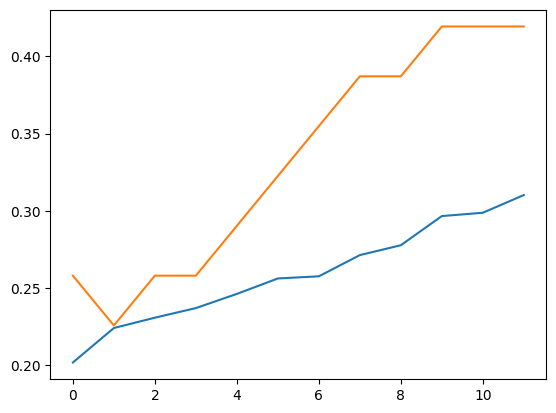

In [ ]:
# 예측 확인.
idx = 55
sns.lineplot(d1[0][idx])
sns.lineplot(d2[0][idx])